In [1]:
from load_data import load_CelebA
from benchmark_1N import Benchmark, SearchTemplate, ArcFaceModel
from attack import prepare_attack_data, run_attack

import matplotlib.pyplot as plt 
import numpy as np

/usr/local/lib/python3.9/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Run with ArcNet as Model and Face Detection Preprocessing

In [2]:
# load 100% of the dataset, use 10% of the identities as only proxies, holdout 5% for testing attack on non-members
gallery_data, proxy_data, gallery_nonmember_data, gallery_otherimages_data = load_CelebA(0.1, 1., 0.05, max_per_id=10)

Files already downloaded and verified
=========CelebA dataset=========
Number of subjects: 10177
Gallery set # subjects: 9119, # images: 81658
Proxy set # subjects: 10177, # images: 29413
# of subjects in proxy only: 1058
Non-member set # subjects:  456
Member set # subjects:  7625


In [3]:
version = 'v1'

In [4]:
model = ArcFaceModel()
benchmark = Benchmark(gallery_data, proxy_data)
# run benchmark for 1:N search without adversarial attack to generate templates once
# benchmark.run_benchmark(model, SearchTemplate(), new_version_name=version, verbose=True) ## Uncomment to run for the first time

benchmark.run_benchmark(model, SearchTemplate(), load_from_version=version, verbose=True)

# Current run (no parallelization):
# Enrolled gallery templates in 311.74 mins.
# Enrolled proxy templates in 230.21 mins.
# (Non-adversarial) 1:N search on gallery templates in 0.70 mins.

/usr/local/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Loading gallery templates from version v1...
Loaded gallery templates from version v1 in 0.00 

In [5]:
print(f'FNR at FPR 0.01 {benchmark.get_fnr_at_fpr_top1(0.01)}')
print(f'FNR at FPR 0.05 {benchmark.get_fnr_at_fpr_top1(0.05)}')

FNR at FPR 0.01 0.9403209049982685
FNR at FPR 0.05 0.0668359690638347


In [6]:
attack_templates, attack_templates_nonmember = prepare_attack_data(gallery_otherimages_data, gallery_nonmember_data, model, n_samples=5)

In [7]:
run_attack(benchmark, model, attack_templates, attack_templates_nonmember, T_match=0.5, T_accuracy=0.5, fpr_stat_threshold=0.05, load_from_version=version)

Loading gallery templates from version v1...
Loaded gallery templates from version v1 in 0.00 mins.
Loading proxy templates from version v1...
Loaded proxy templates from version v1 in 0.00 mins.
Searching for proxy images in gallery...
Search completed in 1.37 mins.
Loading gallery templates from version v1...
Loaded gallery templates from version v1 in 0.00 mins.
Loading proxy templates from version v1...
Loaded proxy templates from version v1 in 0.00 mins.
Searching for proxy images in gallery...
Search completed in 1.26 mins.
Loading gallery templates from version v1...
Loaded gallery templates from version v1 in 0.00 mins.
Loading proxy templates from version v1...
Loaded proxy templates from version v1 in 0.00 mins.
Searching for proxy images in gallery...
Search completed in 1.09 mins.
Loading gallery templates from version v1...
Loaded gallery templates from version v1 in 0.00 mins.
Loading proxy templates from version v1...
Loaded proxy templates from version v1 in 0.00 mins.


(np.float64(0.0),
 np.float64(0.8),
 [np.float64(0.0668359690638347),
  np.float64(0.0668359690638347),
  np.float64(0.0668359690638347),
  np.float64(0.0668359690638347),
  np.float64(0.0668359690638347)],
 [np.float64(1.0),
  np.float64(1.0),
  np.float64(0.0668359690638347),
  np.float64(1.0),
  np.float64(1.0)])

In [9]:
attack_templates, attack_templates_nonmember = prepare_attack_data(gallery_otherimages_data, gallery_nonmember_data, model, new_version_name='v1', n_samples=100)

In [23]:
from benchmark_1N import EnrollTemplates
from sklearn.metrics import roc_curve, auc

gallery_templates = EnrollTemplates('gallery', model)
gallery_templates.load(version)
search = SearchTemplate()


In [24]:
scores_members = []
# Search for attack template member images in gallery
for id, proxy_template in attack_templates.get_templates(as_pairs=True):
    results = search.search(proxy_template, gallery_templates, num_results=1)
    scores_members.append((id, results))

scores_nonmembers = []
# Search for attack template non-member images in gallery
for id, proxy_template in attack_templates_nonmember.get_templates(as_pairs=True):
    results = search.search(proxy_template, gallery_templates, num_results=1)
    scores_nonmembers.append((id, results))

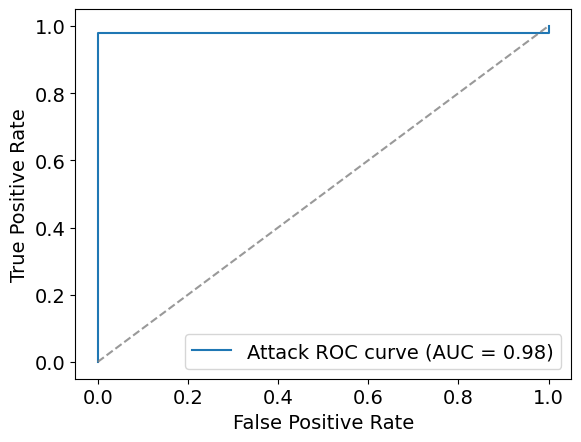

In [ ]:
# Generate ROC curve from scores_members (positives) and scores_nonmembers (negatives)
scores = np.array([score[0][1] if id == score[0][0] else 0 for id, score in scores_members] + [score[0][1] for _, score in scores_nonmembers])
labels = np.array([1] * len(scores_members) + [0] * len(scores_nonmembers))

fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Attack ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', alpha=0.8)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
# make x ticks and y ticks larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.show()

# can achieve TPR of 0.98 at FPR of 0.00